# Characterizing SCAN iSNVs

In this analysis, we look at general characteristis of iSNVs in SCAN SARS-CoV-2 samples with a Ct < 22.

We find that each sample contains a median of 9 variants, and these are primarily low frequency variants.There seems to be evidence for purifying selection as synonymous variants are higher frequency than nonsynonymous variants.

About half of these variants are found in multiple samples with each variant being found in 1.85 samples on average. Variants found in multiple samples are enriched in higher frequency synonymous iSNVs compared to variants found only in one sample.

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [114]:
def load_df(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        df = pd.read_csv(tfile, sep = '\t')
        if 'nwgc_id' in df.columns:
            df['nwgc_id'] = df.nwgc_id.astype('str')
        if 'position' and 'variant' in df.columns:
            df['snv'] = df['position'].astype('str').str.cat(df['variant'],sep="")
    return df

scan_snvs = load_df('../results/snvs_scan_all.tsv')
scan_snvs = scan_snvs[scan_snvs.avg_ct < 22]

## How many SNVs per sample?

(0, 25)

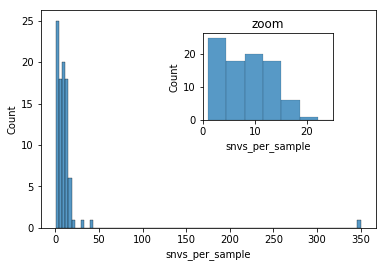

In [115]:
df_sample = pd.value_counts(scan_snvs.nwgc_id).to_frame(name='snvs_per_sample').rename_axis('nwgc_id').reset_index()


fig, ax = plt.subplots()

sns.histplot(df_sample, x='snvs_per_sample', ax=ax)

ax2 = plt.axes([0.5, 0.5, .3, .3])
sns.histplot(df_sample, x='snvs_per_sample', ax=ax2)
ax2.set_title('zoom')
ax2.set_xlim([0,25])


In [116]:
len(df_sample)

91

In [117]:
print(df_sample['snvs_per_sample'].median())

9.0


## What are the frequency of iSNVs?

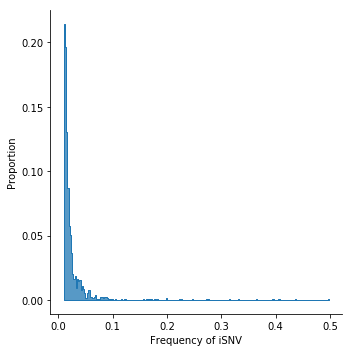

In [118]:
ax = sns.displot(scan_snvs, x='frequency', stat='probability', common_norm=False, element='step')
ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')



In [119]:
print(scan_snvs['frequency'].min())
print(scan_snvs['frequency'].max())
print(scan_snvs['frequency'].median())
print(scan_snvs['frequency'].mean())

0.010007147962830594
0.4981412639405205
0.015873015873015872
0.026473515699633736


## Distribution of synonymous & nonsynonymous variants

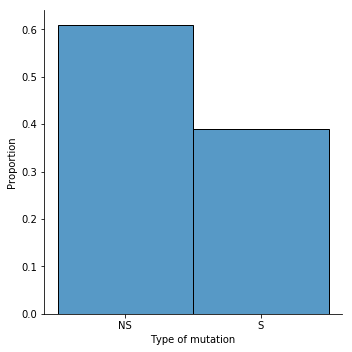

In [9]:
def plot_types(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')

    ax = sns.displot(df, x='mut_type', stat='probability')
    ax.set(ylabel='Proportion', xlabel='Type of mutation')
    return plt.show()

plot_types(scan_snvs)

<function matplotlib.pyplot.show(*args, **kw)>

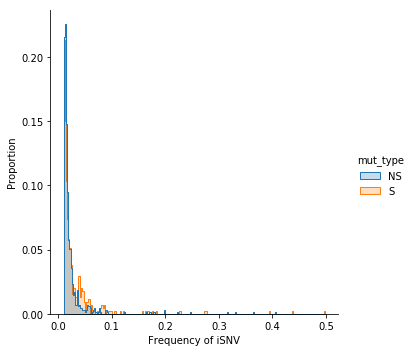

In [10]:
def plot_freq(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')

    ax = sns.displot(df, x='frequency', hue='mut_type', stat='probability', common_norm=False, element='step')
    ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')
    return plt.show

plot_freq(scan_snvs)


Frequency of synonymous iSNVs:

In [11]:
print(scan_snvs.loc[scan_snvs.mut_type=='S', 'frequency'].min())
print(scan_snvs.loc[scan_snvs.mut_type=='S', 'frequency'].max())
print(scan_snvs.loc[scan_snvs.mut_type=='S', 'frequency'].median())
print(scan_snvs.loc[scan_snvs.mut_type=='S', 'frequency'].mean())

0.010019083969465648
0.4981412639405205
0.0176194591924929
0.03092801060171669


Frequency of nonsynonymous iSNVs:

In [12]:
print(scan_snvs.loc[scan_snvs.mut_type=='NS', 'frequency'].min())
print(scan_snvs.loc[scan_snvs.mut_type=='NS', 'frequency'].max())
print(scan_snvs.loc[scan_snvs.mut_type=='NS', 'frequency'].median())
print(scan_snvs.loc[scan_snvs.mut_type=='NS', 'frequency'].mean())

0.010007147962830594
0.4070369498705578
0.015417381753461004
0.023619054885942653


## Labelling variants in multiple samples

In [46]:
def find_multiples(df):
    multiples = df.groupby('snv').filter(lambda x: len(x) > 1)
    snvs = multiples['snv'].unique()
    status = []
    for i in df.index:
        if df.loc[i, 'snv'] in snvs:
            status.append('yes')
        else:
            status.append('no')
    df['in_multiple_samples'] = status
    return df

scan_snvs = find_multiples(scan_snvs)

pd.value_counts(scan_snvs.in_multiple_samples)

yes    585
no     557
Name: in_multiple_samples, dtype: int64

## Number of variants in multiple samples

[Text(0,0.5,'# of iSNVs'), Text(0.5,0,'# of samples iSNV is in')]

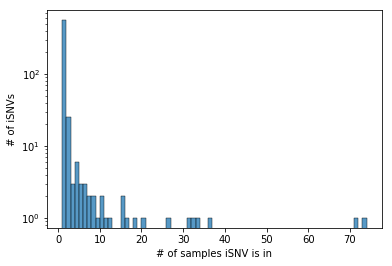

In [28]:
df_multiples = pd.value_counts(scan_snvs.snv).to_frame(name='times_present').rename_axis('snv').reset_index()

fig, ax = plt.subplots()

sns.histplot(data=df_multiples, x='times_present', ax=ax, binwidth=1)
ax.set_yscale("log")
ax.set(ylabel='# of iSNVs', xlabel='# of samples iSNV is in')

In [35]:
print(df_multiples["times_present"].median())
mean = df_multiples["times_present"].mean()
print(mean)
sd = df_multiples["times_present"].std()
print(sd)
print(mean + sd*4)
print(mean + sd*3)

1.0
1.8478964401294498
5.189707783745441
22.606727575111215
17.417019791365774


When looking at distribution of shared variants, should consider tossing any variants in more than 23 samples.

In [36]:
cutoff = mean + sd*4

outliers = df_multiples[df_multiples.times_present > cutoff]["snv"]

In [37]:
outliers

0     9502T
1     1730A
2    19406A
3    13225T
4    25777T
5    21440T
6     8084A
Name: snv, dtype: object

## Frequency of variants in multiple samples

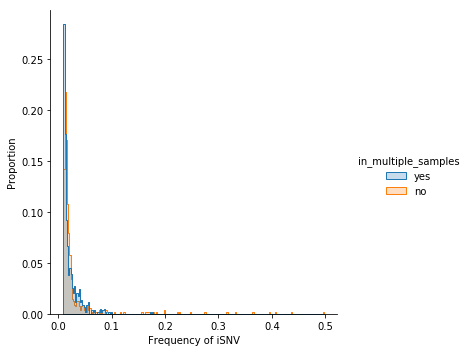

In [38]:
ax = sns.displot(scan_snvs, x='frequency', hue='in_multiple_samples', stat='probability', common_norm=False, element='step')
ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')

Frequency of variants in multiple samples:

In [39]:
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='yes', 'frequency'].min())
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='yes', 'frequency'].max())
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='yes', 'frequency'].median())
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='yes', 'frequency'].mean())

0.010015148964820735
0.17636526410026854
0.015350877192982457
0.022641793526981386


Frequency of variants only found in one sample:

In [40]:
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='no', 'frequency'].min())
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='no', 'frequency'].max())
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='no', 'frequency'].median())
print(scan_snvs.loc[scan_snvs.in_multiple_samples=='no', 'frequency'].mean())

0.010007147962830594
0.4981412639405205
0.016333938294010888
0.030497855863011892


In [41]:
stats.mannwhitneyu(scan_snvs.loc[scan_snvs.in_multiple_samples=='no', 'frequency'], scan_snvs.loc[scan_snvs.in_multiple_samples=='yes', 'frequency'])

MannwhitneyuResult(statistic=148963.0, pvalue=0.006111720698416514)

## Are variants found in multiple samples likely to be NS or S?

<function matplotlib.pyplot.show(*args, **kw)>

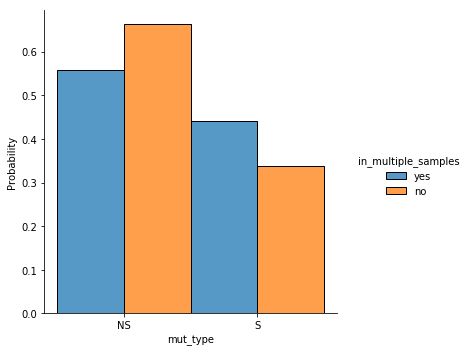

In [42]:
def plot_multiple_snvs(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')

    ax = sns.displot(df, x = 'mut_type', hue = 'in_multiple_samples', multiple='dodge', stat='probability', common_norm=False)
    return plt.show

plot_multiple_snvs(scan_snvs)

In [43]:
def chi2(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')
    cross_tab = pd.crosstab(df['in_multiple_samples'], df['mut_type'])
    chi2, p, dof, ex = stats.chi2_contingency(cross_tab, correction = False)
    return p

chi2(scan_snvs)

0.0003388825813495081

<function matplotlib.pyplot.show(*args, **kw)>

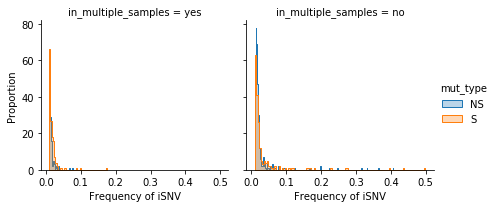

In [56]:
def plot_freq_shared(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')
    limited = df[~df.snv.isin(outliers)]
    g = sns.FacetGrid(limited, col='in_multiple_samples', hue='mut_type', hue_order=['NS', 'S'])
    g.map(sns.histplot,'frequency', element='step', alpha=0.3)
    g.set(ylabel='Proportion', xlabel='Frequency of iSNV')
    g.add_legend()
    return plt.show

plot_freq_shared(scan_snvs)

In [60]:
limited = scan_snvs[~scan_snvs.snv.isin(outliers)]
limited['mut_type'] = limited.mut_type.replace(to_replace='NC', value='S')

/home/cwagner2/miniconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
print(scan_snvs.loc[(scan_snvs.in_multiple_samples=='yes') & (scan_snvs.mut_type=='S'), 'frequency'].mean())
print(scan_snvs.loc[(scan_snvs.in_multiple_samples=='yes') & (scan_snvs.mut_type=='NS'), 'frequency'].mean())
stats.mannwhitneyu(scan_snvs.loc[(scan_snvs.in_multiple_samples=='yes') & (scan_snvs.mut_type=='NS'), 'frequency'], scan_snvs.loc[(scan_snvs.in_multiple_samples=='yes') & (scan_snvs.mut_type=='S'), 'frequency'])

0.026261922432459964
0.019785545032750578


MannwhitneyuResult(statistic=33970.0, pvalue=2.6042125052194947e-05)

In [74]:
print(scan_snvs.loc[(scan_snvs.in_multiple_samples=='no') & (scan_snvs.mut_type=='S'), 'frequency'].mean())
print(scan_snvs.loc[(scan_snvs.in_multiple_samples=='no') & (scan_snvs.mut_type=='NS'), 'frequency'].mean())
stats.mannwhitneyu(scan_snvs.loc[(scan_snvs.in_multiple_samples=='no') & (scan_snvs.mut_type=='NS'), 'frequency'], scan_snvs.loc[(scan_snvs.in_multiple_samples=='no') & (scan_snvs.mut_type=='S'), 'frequency'])

0.03733147202548388
0.027016230284299857


MannwhitneyuResult(statistic=30342.0, pvalue=0.007795216999727812)

Compared to iSNVs found in only one sample, repeated synonymous variants are higher in frequency.

## Where in the genome are iSNVs located?

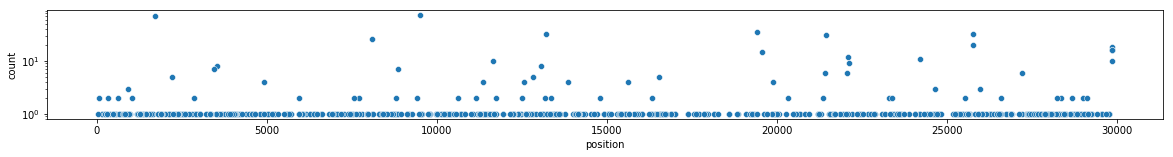

In [45]:
df_location = pd.value_counts(scan_snvs.position).to_frame(name='count').rename_axis('position').reset_index()
plt.figure(figsize=(20,2))
ax = sns.scatterplot(data=df_location, x='position', y='count')
ax.set_yscale("log")


## Where on the tree do iSNVs fall?

In [78]:
# LoadsJSON tree
tree = bt.loadJSON('../../spheres-augur-build/auspice/ncov_washington_all.json')



Tree height: 0.735170
Tree length: 647.110598
multitype tree
annotations present

Numbers of objects in tree: 22913 (10793 nodes and 12120 leaves)



In [ ]:
def extract_washington_subtrees(baltic_tree):
    """
    Code taken from Seattle Flu Augur Build. Function takes in a baltic tree object and returns a list of baltic tree objects.
    Each returned tree object represents a point in the tree in which the tree moved from
    a non-seattle deme into seattle. Note that this will return sub-sub trees, e.g.
    where the clade moves into Washington, leaves Washington, and then strains within that clade
    return to seattle (this scenario would make 2 separate subtrees, even though they are nested).
    If that behavior is not desired, the returned list must be pruned out of any trees that have an
    intersection of internal nodes.
    """
    subtrees_list = []
    for k in sorted(baltic_tree.Objects, key = lambda x:x.height):
        parent = k.parent
        k_division = k.traits['division']
        parent_division = k.parent.traits['division']
        if k_division != parent_division and k_division == 'Washington':
            washington_subtree = baltic_tree.subtree(k)
            subtrees_list.append(washington_subtree)
    return subtrees_list

In [ ]:
def get_basal_subtrees(subtrees_list):
    """
    Given a list of subtrees identified from a baltic_tree, this function removes, sub-subtrees and returns a list of basal subtrees.
    In other words, if the input list contained trees that were subtrees of other trees -- termed basal trees -- in the input list,
    this function only returns the basal trees.
    """
    subtree_leaves = []
    for tree in subtrees_list:
        leaf_list = []
        for k in tree.Objects:
            if isinstance(k,bt.leaf):
                leaf_list.append(k.name)
        subtree_leaves.append(leaf_list)

    non_basal_subtrees = []
    for indexA, leaf_list_A in enumerate(subtree_leaves):
        for indexB, leaf_list_B in enumerate(subtree_leaves):
            if indexA != indexB:
                for leaf in leaf_list_A:
                    if leaf in leaf_list_B:
                        if len(leaf_list_A) < len(leaf_list_B):
                            non_basal_subtrees.append(subtrees_list[indexA])
                        elif len(leaf_list_A) > len(leaf_list_B):
                            non_basal_subtrees.append(subtrees_list[indexB])
                        break

    basal_subtrees = [tree for tree in subtrees_list if tree not in non_basal_subtrees]
    return basal_subtrees

In [ ]:
trees = extract_washington_subtrees(tree)
wa_subtrees = get_basal_subtree(trees)

## Are iSNVs share by transmission cluster?

In [69]:
clusters = load_df('../data/cluster_assignment.tsv')

In [70]:
scan_snvs = scan_snvs.merge(clusters, how='left', on='strain')


In [71]:
def compare_pairwise(df):
    df = df[~df.cluster.isna()]
    df = df.sort_values(by=['cluster', 'avg_ct']).reset_index()
    samples = df['nwgc_id'].unique()
    length = len(samples)
    adj_matrix = np.zeros((length, length, 4))
    for indexA, sampleA in enumerate(samples):
        for indexB, sampleB in enumerate(samples):
            if indexA != indexB:
                dfA = df[df.nwgc_id==sampleA]
                dfB = df[df.nwgc_id==sampleB]
                comparison = 0
                if dfA.cluster.values[0] == dfB.cluster.values[0]:
                    comparison = 1
                df_merged = dfA.merge(dfB, how = 'inner', on ='snv')
                n_shared = len(df_merged.index)
                adj_matrix[indexA, indexB, 0] = n_shared
                adj_matrix[indexB, indexA, 0] = n_shared
                adj_matrix[indexA, indexB, 1] = comparison
                adj_matrix[indexB, indexA, 1] = comparison
    return adj_matrix

matrix = compare_pairwise(scan_snvs)

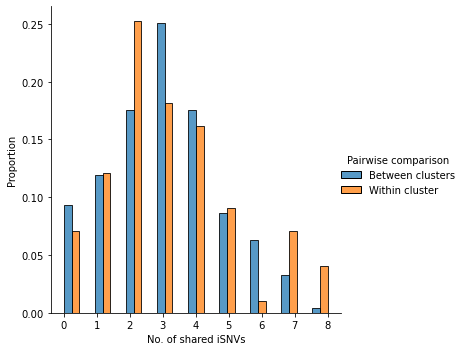

In [72]:
def shared_df(matrix):
    shared_m = matrix[:, :, 0]
    cluster_m = matrix[:, :, 1]
    length = len(shared_m)
    shared = shared_m[np.tril_indices(n=length, k=-1)]
    cluster = cluster_m[np.tril_indices(n=length, k=-1)]
    shared_df = pd.DataFrame({'n_shared':shared, 'cluster_comparison':cluster})
    return shared_df

shared_df = shared_df(matrix)

def plot_shared(df):
    ax = sns.displot(df, x='n_shared', hue = 'cluster_comparison', stat='probability', common_norm=False, multiple='dodge')
    ax.set(ylabel='Proportion', xlabel='No. of shared iSNVs')
    ax._legend.set_title('Pairwise comparison')
    new_labels = ['Between clusters', 'Within cluster']
    for t, l in zip(ax._legend.texts, new_labels): 
        t.set_text(l)
    return plt.show()

plot_shared(shared_df)

## Are iSNVs found in other datasets?

In [63]:
df_snv = pd.value_counts(scan_snvs.snv).to_frame(name='count').rename_axis('snv').reset_index()

muts = scan_snvs[['snv', 'mut_type', 'protein', 'position', 'aa_position']].drop_duplicates()

df_snv = df_snv.merge(muts, how='left')

In [64]:
def load_csv(file):
    '''
    Loads CSV as pandas df
    '''
    with open(file) as cfile:
        df = pd.read_csv(cfile, sep = ',', dtype = {'reference.position': 'Int64'})
        renamed = df.rename(columns={'reference.position': 'position', 'n.individuals': 'n_individuals'})
        renamed['position'] = renamed.position.astype('Int64')
        renamed['n_individuals'] = renamed.n_individuals.astype('Int64')
    return renamed

wi = load_df('../data/WI_iSNVs.tsv')
lythgoe = load_csv('../data/Lythgoe_iSNVs.csv')

In [65]:
def compare_lythgoe(df, lt):
    count = []
    lythgoe = []
    
    for i in df.index:
        pos = df.loc[i, 'position']
        if pos in list(lt.position):
            lythgoe.append('yes')
            lt_count = lt.loc[lt.position==pos, 'n_individuals'].values[0]
            count.append(int(lt_count))
        else:
            count.append(int(0))
            lythgoe.append('no')
    df['count_lythgoe'] = count
    df['in_lythgoe'] = lythgoe
    df.count_lythgoe = df.count_lythgoe.astype('Int64')
    return df

df_variant = compare_lythgoe(df_snv, lythgoe)

In [66]:
def compare_wi(df, wi):
    wi['snv'] = wi['SNV'].str[1:]
    count = []
    wisconsin = []
    
    for i in df.index:
        snv = df.loc[i, 'snv']
        if snv in list(wi.snv):
            wisconsin.append('yes')
            wisconsin_count = wi.loc[wi.snv==snv, 'counts'].values[0]
            count.append(int(wisconsin_count))
        else:
            count.append(int(0))
            wisconsin.append('no')
    df['count_wisconsin'] = count
    df['in_wisconsin'] = wisconsin
    return df

df_variant = compare_wi(df_variant, wi)

In [67]:
def add_dataset(df):
    dataset = []
    for i in df.index:
        lythgoe = df.loc[i, 'in_lythgoe']
        wisconsin = df.loc[i, 'in_wisconsin']
        if lythgoe == 'yes' and wisconsin == 'yes':
            dataset.append('Wisconsin & Lythgoe')
        elif lythgoe == 'yes':
            dataset.append('Lythgoe')
        elif wisconsin == 'yes':
            dataset.append('Wisconsin')
        else:
            dataset.append('Only SCAN')
            
    df['dataset'] = dataset
    return df

df_variant = add_dataset(df_variant)
        

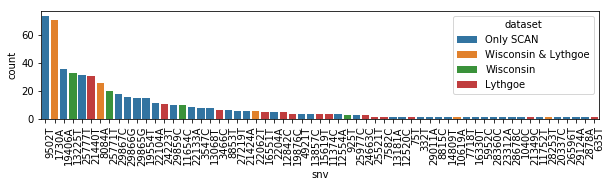

In [68]:
def plot_variants(df):
    pal = sns.color_palette("mako", as_cmap=True)
    sliced = df[df['count']> 1]
    plt.figure(figsize=(10,2))
    ax = sns.barplot(x='snv', y='count', hue='dataset', data=sliced, dodge=False)
    ax.set_xticklabels(labels = sliced['snv'], rotation=90, ha='left')
    return plt.show()

plot_variants(df_variant)

In [95]:
def matching(scan_snvs):
    grouped =  scan_snvs.groupby('strain')
    counter = 0
    for name, group in grouped:
        if counter == 0:
            column_names = list((group['snv']))
            d = {}
            for c in column_names:
                d[c] = 'yes'
            d['strain'] = name
            df = pd.DataFrame(d, index=[0])
            full_df = df
            counter += 1
        else:
            column_names = list((group['snv']))
            d = {}
            for c in column_names:
                d[c] = 'yes'
            d['strain'] = name
            df = pd.DataFrame(d, index=[0])
            full_df = full_df.merge(df, how = 'outer')
    return full_df


matching = matching(scan_snvs)

In [96]:
matching

,1730A,9502T,19406A,21440T,21724A,strain,13225T,23383A,25777T,237T,...,29022C,29081G,29553A,1820T,19269T,25660T,27204T,28476T,9778T,15925T
0,yes,yes,yes,yes,yes,USA/WA-S10/2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yes,yes,yes,yes,NaN,USA/WA-S11/2020,yes,yes,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yes,NaN,yes,NaN,NaN,USA/WA-S110/2020,NaN,NaN,yes,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yes,yes,yes,yes,NaN,USA/WA-S111/2020,yes,NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yes,yes,NaN,NaN,NaN,USA/WA-S1487/2020,yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,yes,NaN,NaN,NaN,NaN,USA/WA-S611/2020,yes,NaN,yes,NaN,...,NaN,NaN,NaN,yes,yes,yes,yes,yes,NaN,NaN
86,yes,yes,yes,yes,NaN,USA/WA-S614/2020,yes,NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN
87,yes,yes,NaN,yes,NaN,USA/WA-S615/2020,yes,NaN,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
88,yes,NaN,NaN,yes,NaN,USA/WA-S616/2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
matching.to_csv('../matching.tsv', sep='\t')

In [109]:
scan_snvs.columns

Index(['strain', 'nwgc_id', 'position', 'variant', 'genome', 'protein',
       'aa_position', 'aa_variant', 'aa_genome', 'mut_type',
       'address_identifier', 'avg_ct', 'individual_identifier', 'age', 'puma',
       'date', 'symptom_onset', 'location', 'frequency', 'batch', 'snv',
       'in_multiple_samples'],
      dtype='object')

In [120]:
multiples_plus = df_multiples.merge(scan_snvs[['snv','variant', 'protein', 'aa_position', 'aa_variant', 'aa_genome', 'mut_type', 'coverage']]).drop_duplicates()

In [121]:
multiples_plus.head(20)

,snv,times_present,variant,protein,aa_position,aa_variant,aa_genome,mut_type,coverage
0,9502T,74,T,ORF1a,3079,A,A,S,418
1,9502T,74,T,ORF1a,3079,A,A,S,8792
2,9502T,74,T,ORF1a,3079,A,A,S,50830
3,9502T,74,T,ORF1a,3079,A,A,S,259332
4,9502T,74,T,ORF1a,3079,A,A,S,24495
5,9502T,74,T,ORF1a,3079,A,A,S,27785
6,9502T,74,T,ORF1a,3079,A,A,S,39824
7,9502T,74,T,ORF1a,3079,A,A,S,2355
8,9502T,74,T,ORF1a,3079,A,A,S,21455
9,9502T,74,T,ORF1a,3079,A,A,S,15212


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

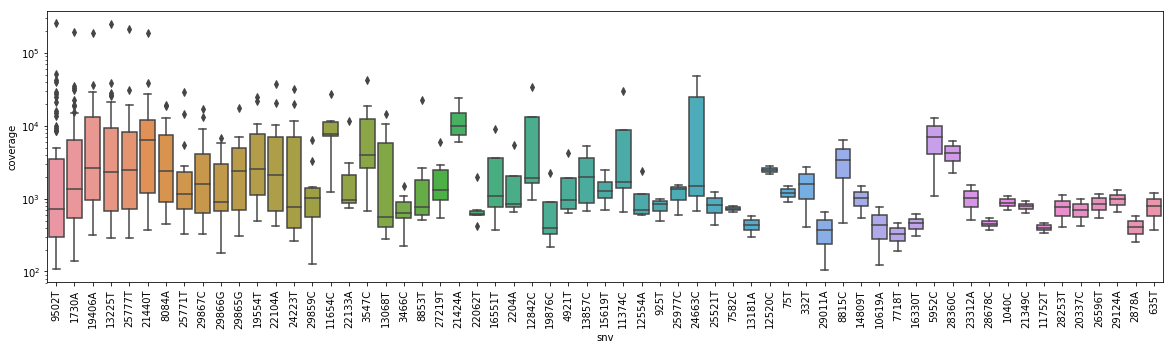

In [137]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=multiples_plus[multiples_plus.times_present > 1], y="coverage", x="snv", orient="v")
ax.set_yscale("log")
plt.xticks(rotation=90)
